In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import arviz as az
import theano as th
import theano.tensor as tt
import warnings
import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from scipy import optimize
from pymc3.gp.util import plot_gp_dist

from plotutils import addtxt
warnings.simplefilter(action='ignore', category=FutureWarning)
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

In [2]:
def K_Linear(x1,x2):
    return np.multiply.outer(x1,x2)
def K_SquareExp(x1,x2,l=1.0):
    return np.exp(-0.5*(np.subtract.outer(x1,x2)/l)**2)
def K_WhiteNoise(x1,x2,σ=1.0):
    r = np.abs(np.subtract.outer(x1,x2))
    return np.where(r == 0, 1.0, 0.0)
def K_OrnsteinUhlenbeck(x1,x2,l=1.0):
    return np.exp(-0.5*np.abs(np.subtract.outer(x1,x2))/l)
def K_Matern32(x1,x2,l=1.0):
    r = np.sqrt(3)*np.abs(np.subtract.outer(x1,x2))/l
    return (1.0 + r)*np.exp(-r)
def K_Matern52(x1,x2,l=1.0):
    r = np.sqrt(5)*np.abs(np.subtract.outer(x1,x2))/l
    return (1.0 + r + r**2/3)*np.exp(-r)

def GP(μ, K, noise): # Rasmussen pg. 201
    return np.random.multivariate_normal(μ, K + np.diag(noise))
def GPfast(μ, K, noise): # Rasmussen pg. 201
    L = np.linalg.cholesky(K + np.diag(noise)) # adding small noise makes calculation more stable
    u = np.random.randn(len(μ))
    return μ + np.dot(L, u)

def GPpost(x_obs, y_obs, noise_obs, x_new, μ, K): # Rasmussen pg. 16
    # return posterior distribution for test data at x* (y*), conditioned on training data at x (y)
    # p(y* | y, x) = GP(μ(x*) + (K*)^t K \ δy, K** - (K*)^t K \ K*) 
    K_obs_obs  = K(x_obs, x_obs) + np.diag(noise_obs) # K
    K_new_new  = K(x_new, x_new) # K**
    K_new_obs  = K(x_new, x_obs) # (K*)^t
    L = np.linalg.cholesky(K_obs_obs)

    # α = K \ δy(x) = L^t \ (L | δy)
    α = np.linalg.solve(L.transpose(), np.linalg.solve(L, y_obs - μ(x_obs)))

    # μpost = μ(x*) + (K*)^t K \ δy(x)
    μpost = μ(x_new) + np.dot(K_new_obs, α) # posterior avg
    
    # Kpost = K** - (K*)^t K | K* = K** - W
    # W_ij  = v_i . v_j 
    # v_i   = (L | c_i) . (L | c_j); c_i the i-th column of K*, i-th row of (K*)^t
    V     = np.array([np.linalg.solve(L, c) for c in K_new_obs]) # V= [v_1, v_2, ...]^t
    Kpost = K_new_new - np.einsum('ik,jk->ij', V, V)
    return μpost, Kpost

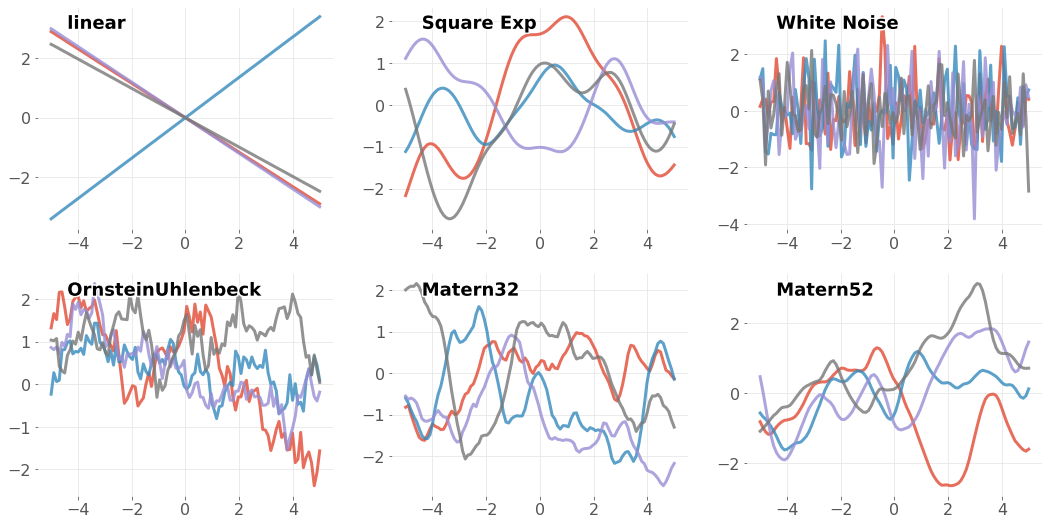

In [3]:
fig, axes = plt.subplots(figsize=(18,9), ncols=3, nrows=2)

Ks = [K_Linear, K_SquareExp, K_WhiteNoise, K_OrnsteinUhlenbeck, K_Matern32, K_Matern52]
Kl = ['linear', 'Square Exp', 'White Noise', 'OrnsteinUhlenbeck', 'Matern32', 'Matern52']
np.random.seed(12357)
x  = np.linspace(-5,5, num=100) # grid
μ  = np.zeros_like(x)
for ax,K,l in zip(axes.flatten(), Ks, Kl):
    addtxt(ax,0.1,0.9,l,fs=18)
    for i in range(4):
        ax.plot(x, GPfast(μ, K(x,x), np.ones_like(x)*1e-6), alpha=0.8)

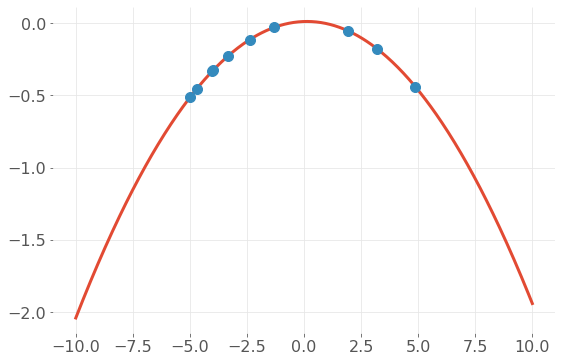

In [4]:
np.random.seed(12357)
x = np.linspace(-10,10,num=500)
y = 1e-2*(1 + 0.5*x - 2*x**2)
i = np.random.choice(len(x)//2,size=10, replace=False) + len(x)//4
xt,yt = x[i], y[i]

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, y)
ax.plot(xt, yt, marker='o', ls='none')
plt.show()

In [5]:
xs            = x
μpost,Kpost   = GPpost(xt, yt,  np.ones_like(yt)*1e-12, xs, lambda x : 0.0, lambda x,y:K_SquareExp(x,y,l=1))
σpost         = np.sqrt(np.diag(Kpost))

# Directly compute average/variance of function at test points
ytest = np.array([GPfast(μpost, Kpost, np.ones_like(xs)*1e-12) for i in range(1000)]) # draw 500 random functions from posterior
yavg  = np.average(ytest, axis=0) # average estimate
ysig  = np.std(ytest, axis=0)     # error estimate

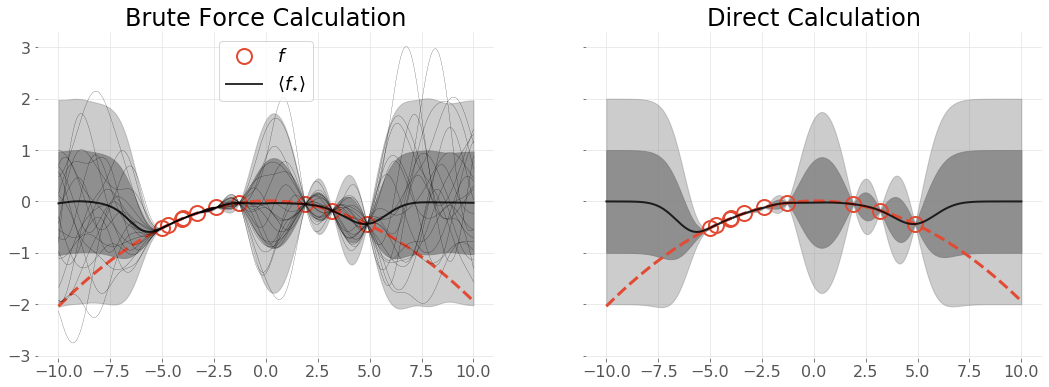

In [6]:
fig, axes = plt.subplots(figsize=(18,6),ncols=2,sharex=True,sharey=True)
for ax in axes:
    l, = ax.plot(x, y, ls='--', lw=3)  # original function
    ax.plot(xt, yt, ls='None', marker='o', ms=15, mec=l.get_color(),mfc='None', label=r'$f$', mew=2) # training data
[ax,bx] = axes

# Brute force calculations of avg/sigma
ax.set_title('Brute Force Calculation')
ax.plot(xs, yavg, lw=2, label=r'$\langle f_{\star}\rangle$', alpha=0.8, color='k') # avg posterior
ax.fill_between(xs, yavg - ysig, yavg + ysig, color='grey', alpha=0.8) # avg+/-sigma
ax.fill_between(xs, yavg - 2*ysig, yavg + 2*ysig, color='grey', alpha=0.4) # avg+/-2sigma
for ys in ytest[::50]:
    ax.plot(xs, ys, lw=0.2, color='k')
ax.legend(fontsize=18)

# Direct calculations
bx.set_title('Direct Calculation')
bx.plot(xs, μpost, lw=2, alpha=0.8, color='k')
bx.fill_between(xs, μpost - σpost, μpost + σpost, color='grey', alpha=0.8)
bx.fill_between(xs, μpost -2*σpost, μpost + 2*σpost, color='grey', alpha=0.4)
plt.show()

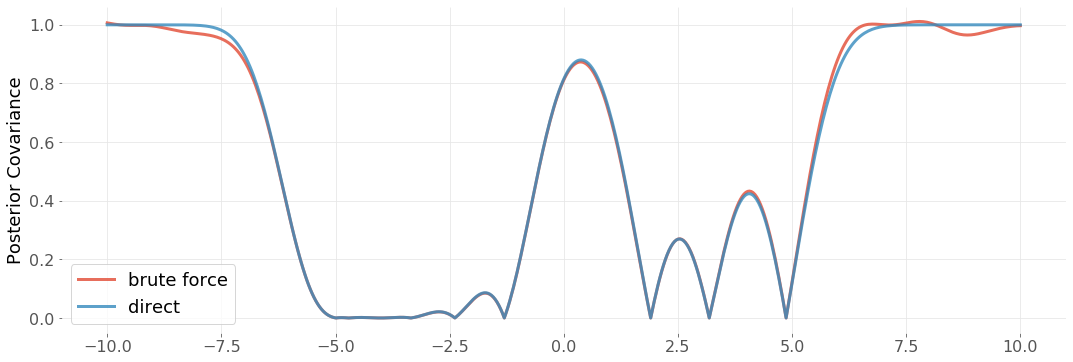

In [7]:
 fig, ax = plt.subplots(figsize=(18,6))
# Brute force calculations of avg/sigma
ax.plot(xs, ysig, lw=3, label='brute force', alpha=0.8)
ax.plot(xs, σpost,lw=3, label='direct', alpha=0.8)
ax.set_ylabel(r'Posterior Covariance', fontsize=18)
ax.legend(fontsize=(18))
plt.show()

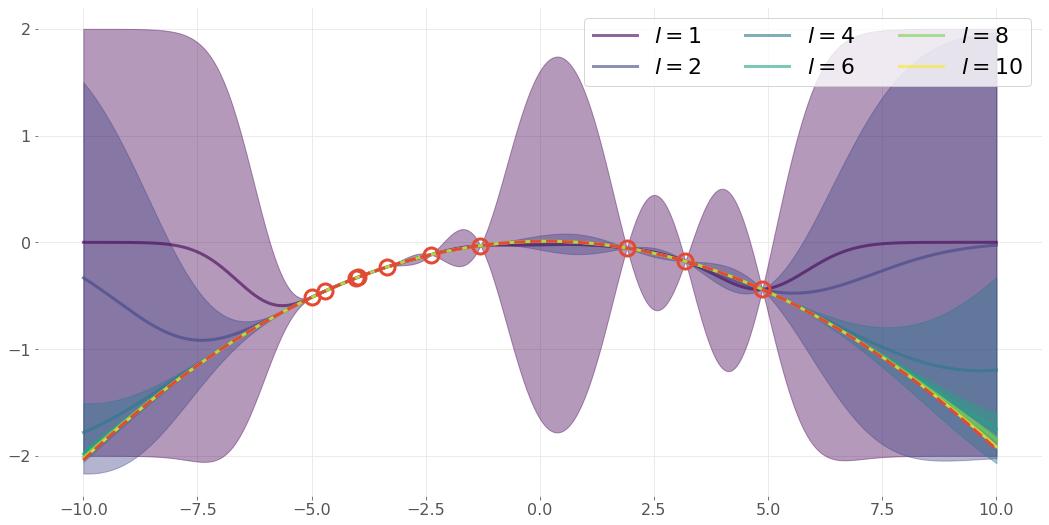

In [8]:
ls      = [1,2,4,6,8,10]
gps     = [GPpost(xt, yt,  np.ones_like(yt)*1e-12, xs, lambda x : 0.0, lambda x,y:K_SquareExp(x,y,l=l)) for l in ls]
fig, ax = plt.subplots(figsize=(18,9))

for gp,c,l in zip(gps, mpl.cm.viridis(np.linspace(0,1,len(gps))), ls):
    mu, K = gp
    sig   = np.sqrt(np.diag(K))
    ax.plot(xs, mu, color=c, alpha=0.6, label=f'$l = {l}$')
    ax.fill_between(xs, mu - 2*sig, mu + 2*sig, color=c, alpha=0.4) # avg+/-2sigma

l, = ax.plot(x, y, ls='--', lw=3)  # original function
ax.plot(xt, yt, ls='None', marker='o', ms=15, mec=l.get_color(),mfc='None', mew=3) # training data

ax.legend(fontsize=22, ncol=3)
plt.show()

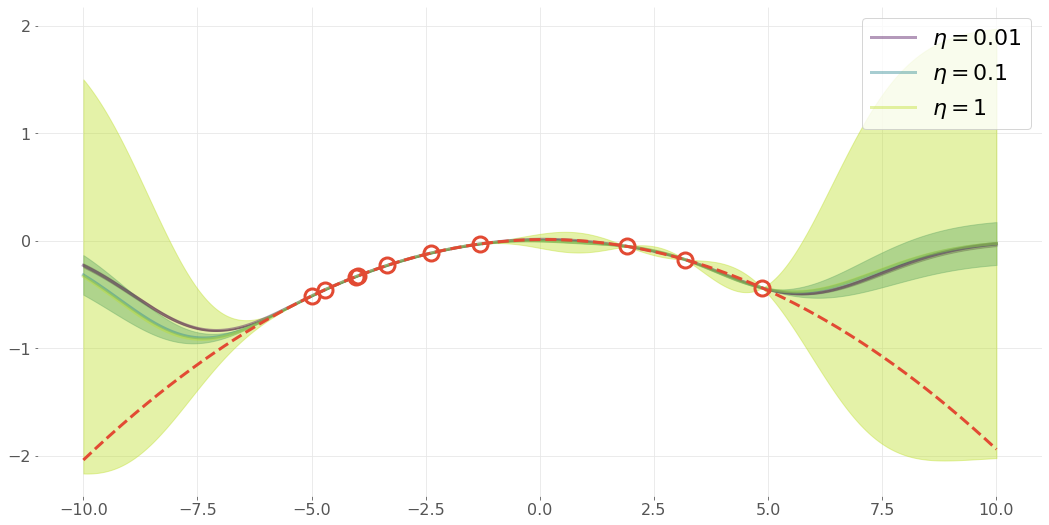

In [9]:
ηs      = [1e-2, 1e-1, 1]
ls      = ['0.01', '0.1', '1']
gps     = [GPpost(xt, yt,  np.ones_like(yt)*1e-12, xs, lambda x : 0.0, lambda x,y:η**2*K_SquareExp(x,y,l=2)) for η in ηs]
fig, ax = plt.subplots(figsize=(18,9))

for gp,c,l in zip(gps, mpl.cm.viridis(np.linspace(0,0.9,len(ηs))), ls):
    mu, K = gp
    sig   = np.sqrt(np.diag(K))
    ax.plot(xs, mu, color=c, alpha=0.4, label=f'$\eta = {l}$')
    ax.fill_between(xs, mu - 2*sig, mu + 2*sig, color=c, alpha=0.4) # avg+/-2sigma

l, = ax.plot(x, y, ls='--', lw=3)  # original function
ax.plot(xt, yt, ls='None', marker='o', ms=15, mec=l.get_color(),mfc='None', mew=3) # training data

ax.legend(fontsize=22)
plt.show()

\begin{align}
P(\theta | D, I) &= \frac{P(D | \theta, I) P(\theta | I)}{P(D | I)}\equiv \frac{L(\theta) \pi(\theta)}{\mathcal{Z}} \propto L(\theta) \pi(\theta)
\end{align}

but since we are assuming our function prior is given by a Gaussian process, 

\begin{align}
L(\theta) &\equiv L(\mu, l, \eta) =  \mathcal{N}(\mu, K(l, \eta))
\end{align}

we can estimate what the parameters $\theta$ should be by computing the maximum of the posterior. As usual, we take maximize the logarithm 

\begin{align}
\log{P(\theta | D, I)} &= \log{L(\theta)} + \log{\pi(\theta)} + \text{const}
\end{align}

Recall that a GP prior is defined as

\begin{align}
\mathcal{GP} \sim \mathcal{N}(\mu, K) = \frac{1}{\sqrt{(2\pi)^n \det{K}}} \exp{\left[-\frac{1}{2}(y - \mu)^{t} K^{-1}(y-\mu)\right]}
\end{align}

For simplicity, assume a squared-exponential function, such that

\begin{align}
K(x_1,x_2; \eta, l) &= \eta^2 \exp{\left[-\frac{(x_1-x_2)^2}{2l^2}\right]}
\end{align}
and
\begin{align}
\log{L} &= -\frac{1}{2}\left[(y-\mu)^t K^{-1} (y - \mu) + n \log{(2\pi)} + \log{\det K}\right]
\end{align}

Let's assume a log-uniform distribution for both $l$ and $\eta$, such that
\begin{align}
\pi(\log{l}) &= \begin{cases}
\textrm{const} & a \le \log{l} \le b  = a + \Delta_l\\
0 & \textrm{otherwise}
\end{cases}\\
\pi(l) &= \frac{1}{b-a} \frac{1}{l} \equiv \frac{1}{\Delta_l} \frac{1}{l}
\end{align}
with equivalent expressions for $\pi(\eta)$ and $\log{\pi(\eta)}$

Thus, the function to maximize, is (taking $\mu = 0$)
\begin{align}
\log{P(\theta | D, I)} &= -\frac{1}{2}\left[y^t K^{-1}(\eta, l) y + \log{\det{K(\eta,l)}} \right] 
- \left[\log{l} + \log{\eta}\right] + \text{const}
\end{align}
where we have assumed that $\pi(\theta) = \pi(l, \eta)= \pi(l) \pi(\eta)$

The jacobian can also be calculated analytically in this case
\begin{align}
\frac{\partial}{\partial l} \log{P(\theta | D, I)} &= \frac{1}{2}\left[y^t K^{-1} \frac{\partial K}{\partial l} K^{-1} y - \textrm{tr}\left(K^{-1} \frac{\partial K}{\partial l}\right) \right] - \frac{1}{l} \\
\frac{\partial}{\partial \eta} \log{P(\theta | D, I)} &= \frac{1}{2}\left[y^t K^{-1} \frac{\partial K}{\partial \eta} K^{-1} y - \textrm{tr}\left(K^{-1} \frac{\partial K}{\partial \eta}\right) \right] - \frac{1}{\eta}
\end{align}

In [10]:
# https://mmas.github.io/optimization-scipy
def gethyperparams(x, y, noise, K):
    def logGP(*,η,l):
        L = η*np.linalg.cholesky(K(x,x,l=l) + np.diag(noise))
        v = np.linalg.solve(L, y)
        return 0.5*np.dot(v,v) + np.sum(np.log(np.diag(L)))
    
    logp = lambda p: (logGP(η = p[0], l = p[1]) + np.log(p[0]) + np.log(p[1]))
    opt0 = optimize.minimize(logp, [1, 1], method='Nelder-Mead', options={'maxiter':2000, 'disp':0}) # downhill simplex
    opt1 = optimize.minimize(logp, opt0['x'], method='Powell', options={'maxiter':2000, 'disp':0})   # conjugate direction method
    opt2 = optimize.minimize(logp, opt1['x'],  method='BFGS', options={'maxiter':1000, 'disp':0})    # quasi-newton method
    return [opt0,opt1,opt2]
opts = gethyperparams(xt, yt, np.ones_like(yt)*1e-12, K_SquareExp)
for o in opts:
    print(f'\t chi2 = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    print(f'\t\t η = {o["x"][0]:6.3f}, l = {o["x"][1]:6.3f}')

	 chi2 = -5.098338e+01, niter =    60, Converged =      1 : Optimization terminated successfully.
		 η =  3.247, l = 10.858
	 chi2 = -5.098342e+01, niter =     1, Converged =      1 : Optimization terminated successfully.
		 η =  3.241, l = 10.858
	 chi2 = -5.098342e+01, niter =     0, Converged =      0 : Desired error not necessarily achieved due to precision loss.
		 η =  3.241, l = 10.858


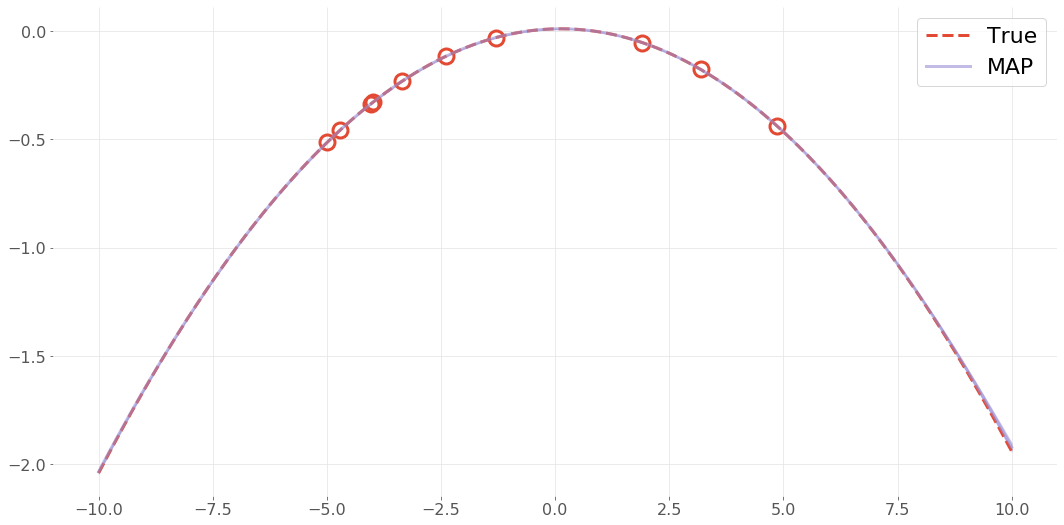

In [11]:
fig, ax    = plt.subplots(figsize=(18,9))
ηopt, lopt = opts[0]['x']
μopt, Kopt = GPpost(xt, yt,  np.ones_like(yt)*1e-12, xs, lambda x : 0.0, lambda x,y:ηopt**2*K_SquareExp(x,y,l=lopt))
σopt       = np.sqrt(np.diag(Kopt))

l, = ax.plot(x, y, ls='--', lw=3, label='True')  # original function
ax.plot(xt, yt, ls='None', marker='o', ms=15, mec=l.get_color(),mfc='None', mew=3) # training data

l, = ax.plot(xs, μopt, alpha=0.6, label='MAP')
ax.fill_between(xs, μopt - 2*σopt, μopt + 2*σopt, color=l.get_color(), alpha=0.4) # avg+/-2sigma

ax.legend(fontsize=22)
plt.show()

In [12]:
# https://mmas.github.io/optimization-scipy
def gethyperparams2(x, y, noise):
    K   = K_SquareExp
    aux = np.zeros((2,len(x),len(x)))

    def gradGP(w,L,dK):
        aux[0,...] = np.transpose([np.linalg.solve(L, a) for a in dK]) # (L | dK)^t
        aux[1,...] = [np.linalg.solve(L, a) for a in aux[0]]           # L | (L | dK)^t
        return 0.5*(np.linalg.multi_dot([w, dK, w]) - np.trace(aux[1]))

    def logp(p):
        η, l = p
        Σ = K(x,x,l=l)
        L = η*np.linalg.cholesky(Σ + np.diag(noise))
        v = np.linalg.solve(L, y)
        w = np.linalg.solve(np.transpose(L), v)
        
        logGP = 0.5*np.dot(v,v) + np.sum(np.log(np.diag(L)))
        logPI = np.log(η) + np.log(l)
        return (logGP + logPI)/len(x)
    def logp_jac(p):
        η, l = p
        Σ = K(x,x,l=l)
        L = η*np.linalg.cholesky(Σ + np.diag(noise))
        v = np.linalg.solve(L, y)
        w = np.linalg.solve(np.transpose(L), v)
        
        logGP = 0.5*np.dot(v,v) + np.sum(np.log(np.diag(L)))
        logPI = np.log(η) + np.log(l)

        # grad_eta logp
        dK      = 2*η*Σ
        grad_η  = gradGP(w,L,dK) - 1.0/η
        
        # grad_l logp
        dK[...] = η**2*Σ*(np.subtract.outer(x,x)/l)**2/l
        grad_l  = gradGP(w,L,dK) - 1.0/l
        
        return (logGP + logPI)/len(x) , -np.array([grad_η, grad_l])/len(x)
    
    opt0 = optimize.minimize(logp, [100, 100], method='Nelder-Mead', options={'maxiter':2000, 'disp':0})                                # downhill simplex
    opt1 = optimize.minimize(logp_jac, opt0['x'],  method='BFGS', options={'maxiter':1000, 'disp':0},jac=True) # conjugate gradient
    return [opt0,opt1]

opts2 = gethyperparams2(xt, yt, np.ones_like(yt)*1e-12)
for o in opts2:
    print(f'\t chi2 = {o["fun"]:12.6e}, niter = {o["nit"]:5d}, Converged = {o["success"]:6b} : {o["message"]}')
    print(f'\t\t η = {o["x"][0]:6.3f}, l = {o["x"][1]:6.3f}')

	 chi2 = -5.276253e+00, niter =    50, Converged =      1 : Optimization terminated successfully.
		 η =  7.796, l = 20.498
	 chi2 = -5.276253e+00, niter =     0, Converged =      0 : Desired error not necessarily achieved due to precision loss.
		 η =  7.796, l = 20.498


In [13]:
with pm.Model() as model:
    log_eta = pm.Uniform('log_eta', lower=-6, upper=6)
    eta     = pm.Deterministic('eta', tt.exp(log_eta))

    log_l   = pm.Uniform('log_l', lower=-6,upper=6)
    l       = pm.Deterministic('l', tt.exp(log_l))


    cov     = eta**2*pm.gp.cov.ExpQuad(1, ls=l)
    gp      = pm.gp.Marginal(cov_func=cov)

    y_obs   = gp.marginal_likelihood("y_obs", X=xt[:,None], y=yt, noise=1e-3*np.ones_like(yt))
    trace   = pm.sample(draws=5000, tune=10000, progressbar=True)
    fit     = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_l, log_eta]
Sampling 2 chains: 100%|██████████| 30000/30000 [01:12<00:00, 415.63draws/s]
The acceptance probability does not match the target. It is 0.9155211007425385, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/opt/anaconda3/envs/ML/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 24.669, ||grad|| = 0.0039803: 100%|██████████| 24/24 [00:00<00

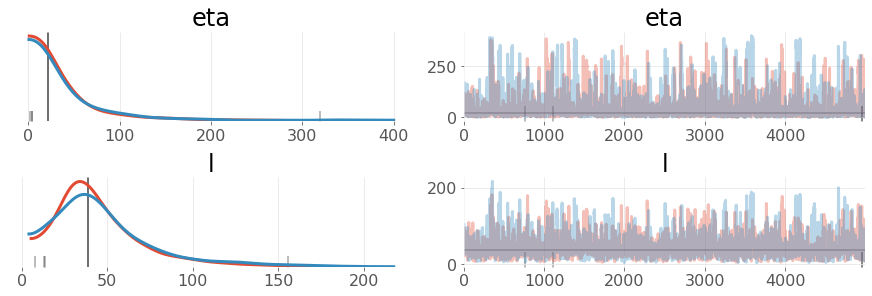

In [14]:
pm.traceplot(trace, lines = [('eta', {}, fit['eta']),
                             ('l', {}, fit['l'])],
             var_names=['eta', 'l']);

In [15]:
pprint.pprint(fit)

{'eta': array(21.52942096),
 'l': array(38.82693463),
 'log_eta': array(3.06942042),
 'log_eta_interval__': array(1.12970815),
 'log_l': array(3.6591142),
 'log_l_interval__': array(1.41737254)}


In [16]:
μMAP,KMAP = GPpost(xt, yt,  np.ones_like(yt)*1e-12, xs, lambda x : 0.0, lambda x,y:fit['eta']**2*K_SquareExp(x,y,l=fit['l']))
σMAP      = np.sqrt(np.diag(KMAP))

In [17]:
with model:
    y_pred = gp.conditional('y_pred', x[:,None])

In [18]:
with model:
    y_samples = pm.sample_posterior_predictive(trace, vars=[y_pred], samples=500)

100%|██████████| 500/500 [01:08<00:00,  7.45it/s]


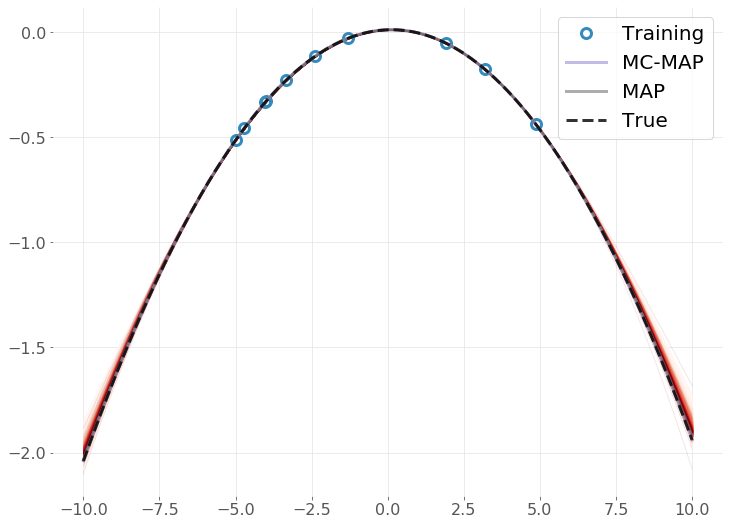

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
plot_gp_dist(ax, y_samples['y_pred'], x)
ax.plot(xt,yt, ls='None', marker='o',mfc='None', mew=3, label='Training', color='C1')
ax.plot(xs, μMAP, alpha=0.6, label='MC-MAP', color='C2')
ax.plot(xs, μopt, alpha=0.6, label='MAP', color='C3')
ax.plot(x,y,lw=3,color='k', alpha=0.8,ls='--', label='True')
ax.legend(fontsize=20)
plt.show()